### <b>Butterfly classification

In [2]:
import numpy as np
import pandas as pd
import os

data_dir = "/mnt/d/MyProject/Datasets/Butterflies"

train_df = pd.read_csv(data_dir + "/train.csv")
test_df = pd.read_csv(data_dir + "/test.csv")
print(train_df.shape)
print(test_df.shape)
train_df.head()

(6499, 2)
(2786, 1)


,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
import tensorflow as tf
from keras import (models , layers , optimizers , preprocessing , initializers)
from sklearn.preprocessing import StandardScaler , LabelEncoder
import cv2
import matplotlib.pyplot as plt


In [4]:
from concurrent.futures import ThreadPoolExecutor

# prepare data
data_folder = data_dir + "/train/"

suffix = train_df.to_numpy()[: , 0]
suffix = data_folder + suffix

def load_image(arr: np.ndarray):

    def process_image(path):
        img = preprocessing.image.load_img(path, target_size=(150, 150))
        img = preprocessing.image.img_to_array(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ensure RGB format
        return img

    with ThreadPoolExecutor() as executor:
        images = list(executor.map(process_image, arr))

    images = np.array(images)
    return images
"""extract images and labels"""
train_images = load_image(suffix)
labels = train_df.to_numpy()[: , 1]

print(train_images[:1])
labels[:5]

[[[[ 31.  43.  25.]
   [ 29.  42.  26.]
   [ 29.  42.  26.]
   ...
   [ 18.  40.  28.]
   [ 23.  47.  35.]
   [ 33.  59.  46.]]

  [[ 30.  45.  24.]
   [ 27.  43.  25.]
   [ 25.  44.  25.]
   ...
   [ 39.  64.  54.]
   [ 42.  69.  59.]
   [ 48.  78.  67.]]

  [[ 28.  45.  24.]
   [ 25.  44.  25.]
   [ 24.  43.  24.]
   ...
   [ 50.  77.  68.]
   [ 52.  81.  72.]
   [ 53.  87.  77.]]

  ...

  [[ 59.  95.  59.]
   [ 66. 110.  71.]
   [ 73. 120.  82.]
   ...
   [ 23.  58.  38.]
   [ 26.  65.  44.]
   [ 26.  70.  47.]]

  [[ 61.  97.  61.]
   [ 63. 107.  68.]
   [ 75. 122.  84.]
   ...
   [ 22.  59.  39.]
   [ 24.  63.  41.]
   [ 21.  67.  44.]]

  [[ 69. 104.  70.]
   [ 68. 111.  74.]
   [ 81. 128.  90.]
   ...
   [ 19.  61.  38.]
   [ 19.  65.  42.]
   [ 21.  69.  43.]]]]


array(['SOUTHERN DOGFACE', 'ADONIS', 'BROWN SIPROETA', 'MONARCH',
       'GREEN CELLED CATTLEHEART'], dtype=object)

<b>View some img

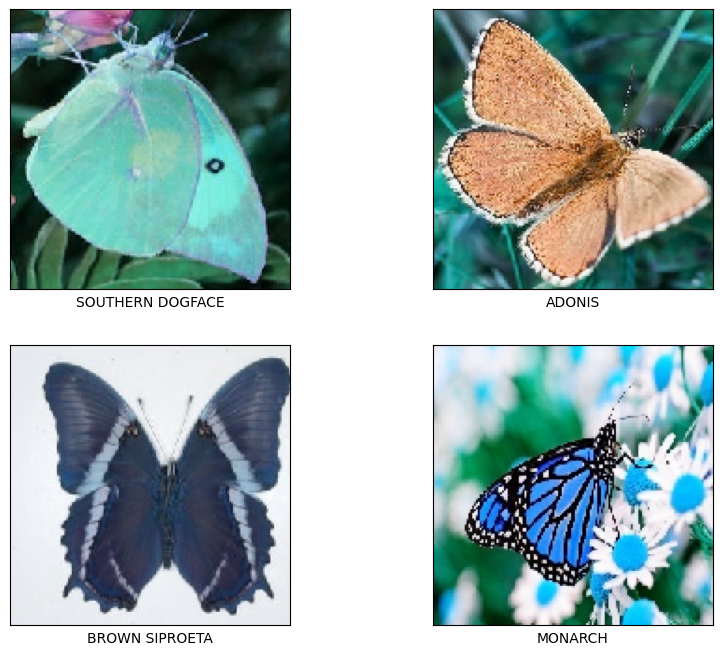

In [5]:
subset_img = train_images[:4]

plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2 , 2 , i + 1)
    plt.imshow(subset_img[i].astype('uint8'), cmap=None)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(labels[i])    

plt.show()

DATA ENCODE

In [6]:
print(labels)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
n_classes = len(label_encoder.classes_)

print(f"num classes: {n_classes}")

['SOUTHERN DOGFACE' 'ADONIS' 'BROWN SIPROETA' ... 'APPOLLO'
 'ELBOWED PIERROT' 'ATALA']
num classes: 75


In [7]:
train_images = train_images / 255

In [8]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, labels, test_size=0.2, random_state=42  # 20% for validation
)
print(f"Training images: {len(train_images)}, Validation images: {len(val_images)}")

Training images: 5199, Validation images: 1300


<b>BUILDING MODEL

In [9]:
model = models.Sequential([
    layers.InputLayer((150,150,3)),

    layers.Conv2D(64 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.05),

    layers.Conv2D(128 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.05),

    layers.Conv2D(256 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.08),

    layers.Conv2D(512 , (3,3) , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.08),

    layers.Flatten(),

    layers.Dense(64 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(128 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(256 , activation='relu' , kernel_initializer=initializers.HeUniform()),
    layers.Dropout(0.1),

    layers.Dense(n_classes , activation='softmax')
])

model.summary()

I0000 00:00:1743692114.445725   14980 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 36, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 17, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             

 Total params: 3,221,131 (12.29 MB)

 Trainable params: 3,219,211 (12.28 MB)

 Non-trainable params: 1,920 (7.50 KB)

<b>Compile model

In [10]:
model.compile(optimizer=optimizers.Adam(0.0001) , loss="sparse_categorical_crossentropy" , metrics=["accuracy"])

<b>Use Image Data Generator

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

datagen = ImageDataGenerator(
    rotation_range=10,         # Reduce rotation
    width_shift_range=0.1,     # Reduce horizontal shift
    height_shift_range=0.1,    # Reduce vertical shift
    shear_range=0.1,           # Reduce shearing
    zoom_range=0.1,            # Reduce zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(train_images)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [13]:
history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=32),  # Augmented training data
    validation_data=(val_images, val_labels),          # Validation data
    epochs=100,                                         # Number of epochs
    steps_per_epoch=len(train_images) // 32,          # Steps per epoch
    validation_steps=len(val_images) // 32,           # Validation steps
    callbacks=callbacks                                  # Add callbacks like EarlyStopping if needed
)

Epoch 1/100


/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743692136.570746   15298 service.cc:152] XLA service 0x7f7084017e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743692136.570798   15298 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-04-03 22:55:36.643562: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743692137.022125   15298 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-03 22:55:38.395453

  1/162 ━━━━━━━━━━━━━━━━━━━━ 33:10 12s/step - accuracy: 0.0000e+00 - loss: 5.2066

I0000 00:00:1743692146.899287   15298 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


104/162 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.0286 - loss: 4.9114

2025-04-03 22:55:54.298417: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4037', 288 bytes spill stores, 288 bytes spill loads

2025-04-03 22:55:54.383928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4585', 424 bytes spill stores, 424 bytes spill loads

2025-04-03 22:55:54.697039: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4585', 432 bytes spill stores, 432 bytes spill loads



162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0379 - loss: 4.7726

2025-04-03 22:56:04.385649: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_176', 172 bytes spill stores, 172 bytes spill loads

2025-04-03 22:56:04.829002: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_169', 128 bytes spill stores, 128 bytes spill loads

2025-04-03 22:56:05.250660: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_169', 104 bytes spill stores, 116 bytes spill loads

2025-04-03 22:56:08.185834: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_162', 8 bytes spill stores, 8 bytes spill loads



162/162 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.0381 - loss: 4.7707 - val_accuracy: 0.0392 - val_loss: 4.2747 - learning_rate: 1.0000e-04
Epoch 2/100
  1/162 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.0312 - loss: 3.7961

/home/zihao/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0312 - loss: 3.7961 - val_accuracy: 0.0323 - val_loss: 4.3016 - learning_rate: 1.0000e-04
Epoch 3/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.1223 - loss: 3.8827 - val_accuracy: 0.1362 - val_loss: 3.5425 - learning_rate: 1.0000e-04
Epoch 4/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 3.8636 - val_accuracy: 0.1423 - val_loss: 3.5347 - learning_rate: 1.0000e-04
Epoch 5/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.1750 - loss: 3.4555 - val_accuracy: 0.2554 - val_loss: 2.9021 - learning_rate: 1.0000e-04
Epoch 6/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 2.8705 - val_accuracy: 0.2608 - val_loss: 2.8999 - learning_rate: 1.0000e-04
Epoch 7/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.2289 - loss: 3.1609 - val_accuracy: 0.3462 - val_loss: 2.5559 - learning_rate: 1.0000e-04
Epoch 8/100
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy:

<b>Save model

In [17]:
model.save("Butterfly.keras")

In [16]:
print(history.history)

{'accuracy': [0.05999612808227539, 0.03125, 0.13566866517066956, 0.21875, 0.18753628432750702, 0.25, 0.24230694770812988, 0.375, 0.28275594115257263, 0.21875, 0.3247532546520233, 0.3125, 0.36268627643585205, 0.4375, 0.37487903237342834, 0.375, 0.40139347314834595, 0.4375, 0.41629573702812195, 0.59375, 0.4420360028743744, 0.4375, 0.4627443253993988, 0.375, 0.4737758934497833, 0.46875, 0.4900329113006592, 0.5, 0.5062898993492126, 0.40625, 0.5146119594573975, 0.4375, 0.5492548942565918, 0.5, 0.5626088380813599, 0.625, 0.5771240592002869, 0.625, 0.5763499140739441, 0.5, 0.5924133658409119, 0.59375, 0.6090574860572815, 0.59375, 0.6113799214363098, 0.65625, 0.6152506470680237, 0.71875, 0.6276369094848633, 0.65625, 0.6369266510009766, 0.53125, 0.642345666885376, 0.5625, 0.6469905376434326, 0.53125, 0.65318363904953, 0.625, 0.6568608283996582, 0.53125, 0.6618927717208862, 0.65625, 0.6640216708183289, 0.625, 0.670214831829071, 0.75, 0.6529901027679443, 0.78125, 0.6760209202766418, 0.71875, 0.67

<b>Visualize training process

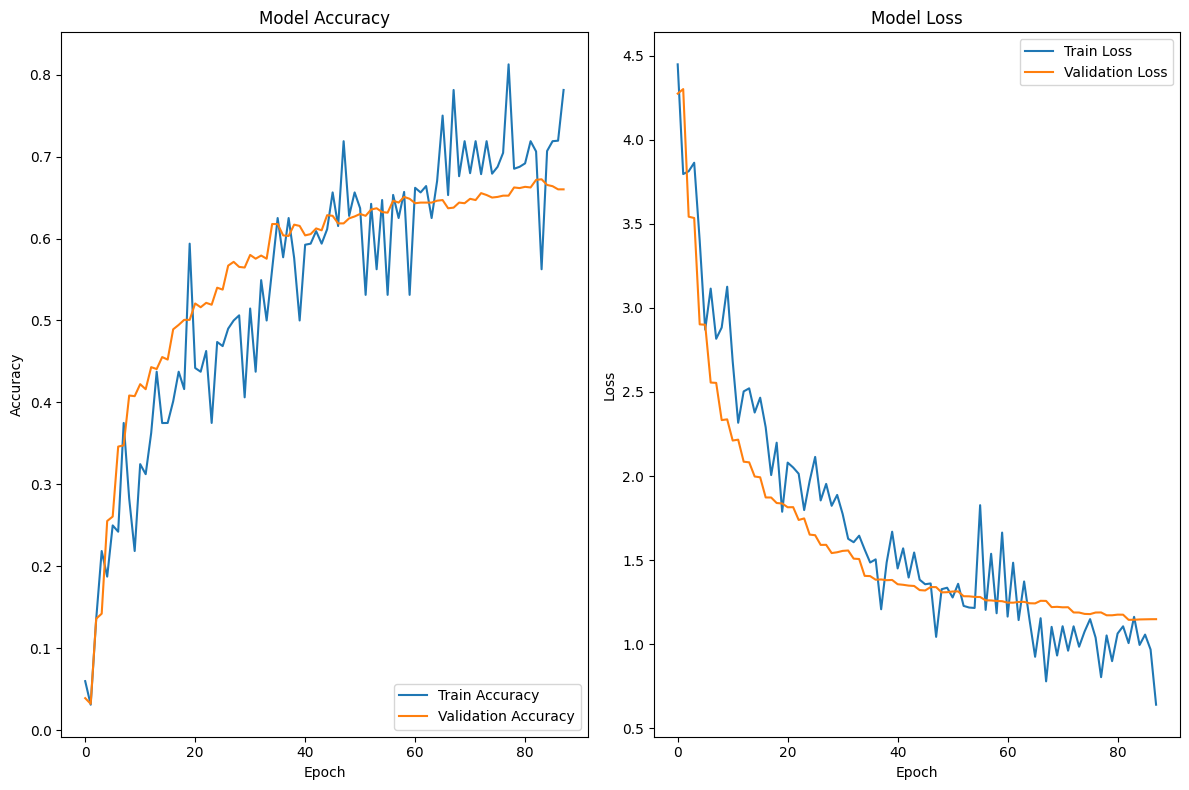

In [15]:
plt.figure(figsize=(12, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()